### About

### Estimate AOD(Aerosol Optical Depth) using Sentinel-2 data, leveraging its spectral bands and spatial resolution to improve accuracy.



### This notebook is about estimating Aerosol Optical Depth using RGB composites.



### The AOD estimation process,

- Select type of RGB composite

- create embedding

- train the xgboost model using the embedding vectors

### Competition hosted on [Solafune](https://solafune.com/competitions/ca6ee401-eba9-4f7d-95e6-d1b378a17200?menu=about&tab=overview&modal=%22%22)

### Competition policy
### cf. @solafune(https://solafune.com) Use for any purpose other than participation in the competition or commercial use is prohibited. If you would like to use them for any of the above purposes, please contact us.

### Import necessary packages and libraries

In [1]:
!pip install imagecodecs -qq

In [2]:
import pandas as pd #dataframe manipulation

import numpy as np  #for numerical process

import seaborn as sns #for visualization

from matplotlib import pyplot as plt #for visualization

from PIL import Image, ImageDraw, ImageEnhance,ImageStat #for read the image

import skimage.color 

import skimage.io as skio

from skimage.transform import resize

import skimage.util

from skimage.measure import shannon_entropy, blur_effect

import imagehash #for calculation hash value of image

import cv2 #for read the image

import re

import os

import itertools

import os

#import distance

import time

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

from tqdm import tqdm_notebook,tqdm

from IPython.display import display, HTML

import tifffile

import shutil

from tqdm import tqdm

import json

import random



from sklearn.model_selection import train_test_split,KFold

import logging

from IPython.display import clear_output






import xgboost as xgb

import torch

import timm

from torchvision import transforms

import tifffile

### Import data

In [3]:
train = pd.read_csv("/kaggle/input/train_answer.csv")



train = train.rename(columns = {'train_1.tif':'filename'})

train = train.rename(columns = {'0.04161685225788304':'label'})

test = pd.DataFrame({'filename':[f"test_{i}.tif" for i in range(1,1490)]})





train_path = "/kaggle/input/train_images/train_images/"

test_path = "/kaggle/input/test_images/test_images/"

In [4]:
bands = {'B1_Aerosols':0,'B2_Blue':1,'B3_Green':2,'B4_Red':3,

'B5_Red_Edge_1':4,'B6_Red_Edge_2':5,'B7_Red_Edge_3':6,

'B8_NIR':7,'B8A_Red_Edge_4':8,'B9_Water_vapor':9,'SWIR_Cirrus':10,'B11_SWIR_1':11,

'B12_SWIR_2':12}

In [5]:
band_combo={'Natural_Colors':[bands['B4_Red'],bands['B3_Green'],bands['B2_Blue']],
'False_color_Infrared':[bands['B8_NIR'],bands['B4_Red'],bands['B3_Green']],
'False_color_Urban':[bands['B12_SWIR_2'],bands['B11_SWIR_1'],bands['B4_Red']],
'Agriculture':[bands['B11_SWIR_1'],bands['B8_NIR'],bands['B12_SWIR_2']],
'Atmospheric_Penetration':[bands['B12_SWIR_2'],bands['B11_SWIR_1'],bands['B8A_Red_Edge_4']],
'Healthy_Vegetation':[bands['B8_NIR'],bands['B11_SWIR_1'],bands['B12_SWIR_2']],
'Land_Water':[bands['B8_NIR'],bands['B11_SWIR_1'],bands['B4_Red']],
'Natural_Colors_with_Atmospheric_Removal':[bands['B12_SWIR_2'],bands['B8_NIR'],bands['B3_Green']],
'Shortwave_Infrared':[bands['B12_SWIR_2'],bands['B8_NIR'],bands['B4_Red']],
'Vegetation_Analysis':[bands['B11_SWIR_1'],bands['B8_NIR'],bands['B4_Red']]}

### Split data

In [6]:
X_train, X_test = train_test_split(train, test_size=0.2,random_state=42)                                                                

### Embedding model

In [7]:
model_name = 'efficientnet_b0.ra_in1k'

model = timm.create_model(model_name, pretrained=True, num_classes=0,in_chans=3)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

### Convert image to tensor

In [8]:
# Define the transform pipeline: resize, normalize, and convert to tensor

transform = transforms.Compose([

    transforms.Resize((512, 512)),  # Resize the image to 224x224

    transforms.ToTensor(),  # Convert the image to a PyTorch tensor

    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize

])


### Function to get embedding

In [9]:
def get_image_embedding(df,path,bands):

    embed=[]

    for img in tqdm(df['filename']):

        #im=rasterio.open(f"{path}{img}").read().astype(np.float64)

        
        
        image = open_image(f"{path}{img}",bands)

        

        # Apply the transformations

        image = transform(image)

        

        # Add a batch dimension (N, C, H, W) for the model input

        image = image.unsqueeze(0)

        

         # Ensure the model is in evaluation mode

        model.eval()



        # Disable gradient calculation for inference

        with torch.no_grad():

            embedding = model(image)

        embed.append(embedding.detach().cpu().numpy())

        del image,embedding

    return embed

### Evaluation metric

In [10]:
from scipy.stats import pearsonr



def pearsonr_eval(preds, dtrain):

    labels = dtrain.get_label()

    return 'pearsonr', pearsonr(preds, labels)[0]


### Function to read image

In [11]:
def open_image(path,bands):

    img=tifffile.imread(path)

    new_image = np.dstack((img[:,:,bands[0]],

                      img[:,:,bands[1]],img[:,:,bands[2]]))

   

                        

    new_image = Image.fromarray((new_image*255).astype(np.uint8))

    

    #new_image = new_image.resize((512,512))

    

    return new_image

   

### AOD model

In [12]:
len(band_combo.keys())

10

In [13]:
class AodModel():

    def __init__(self,train_df, val_df, train_label, val_label, test_df, train_path, test_path):

        self.train_df = train_df

        self.val_df = val_df

        self.train_label = train_label

        self.val_label = val_label

        self.test_df =  test_df

        self.train_path = train_path

        self.test_path = test_path

        self.score = dict()

        self.val_pred_results = dict()

        self.test_pred_results = dict()

        self.final_sub = dict()

    def train_model(self):
        for i,band in enumerate(band_combo.keys()):

            band_index = [band_combo[band][0],band_combo[band][1],band_combo[band][2]]

            print(f"Prepaing training data for {band}\n")

            train_embeddings=get_image_embedding(self.train_df ,self.train_path ,band_index)

            print(f"training data preparation for {band} is done\n")

        

            print(f"Preparing validation data for {band}\n")

            validation_embeddings=get_image_embedding(self.val_df ,self.train_path ,band_index)

            print(f"Validation data preparation for {band} is done\n")

            

            print(f"Training model for {band}\n")

            #xgboost model

            reg=xgb.XGBRegressor(random_state=42)

            reg.fit(np.concatenate(train_embeddings), self.train_label,

                eval_set=[(np.concatenate(validation_embeddings),self.val_label)],

                eval_metric=pearsonr_eval,

                early_stopping_rounds=200, verbose=False)

            val_pred = reg.predict(np.concatenate(validation_embeddings))

            score_result = pearsonr(self.val_label,val_pred,)[0].round(2)*100 

            print(f"{band} Validation  pearsonr:{score_result}\n")

            self.val_pred_results[f"{band}"] = val_pred

            self.score[f"{band}"] = score_result

            print(f"Testing data preparation for {band}\n")

            test_embedding = get_image_embedding(self.test_df, self.test_path ,band_index)

            print(f"Testing data preparation for {band} is done\n")

            print(f"Predict test data for {band}\n")

            test_pred = reg.predict(np.concatenate(test_embedding))

            self.test_pred_results[f"{band}"] = test_pred

            print(f"Test Prediction is done for {band}\n")

            print("="*100)
        self.create_test_result_df()



    def create_test_result_df(self):

        for key, value in self.test_pred_results.items():

            self.final_sub[key] = pd.DataFrame({'fielname':self.test_df['filename'],'AOD':value})



        os.makedirs("/kaggle/working/Popular_RGB_Composites_prediction", exist_ok = True)

        os.chdir("/kaggle/working/Popular_RGB_Composites_prediction/")

        ref_name = "efficientnet_b0.ra_in1k_embeddings_xgb_baseline"

        

        for key, value in self.final_sub.items():

            value.to_csv(f"{ref_name}_{key}.csv", index=False, header=False)



        pd.DataFrame(list(self.score.items()),columns=['RGB_Composites', 'Validation_score']).to_csv(f"{ref_name}_RGB_Composites_validation_results.csv",index=False)

        os.chdir("/kaggle/working/")

        shutil.make_archive(f"{ref_name}_RGB_Composites", 'zip', "/kaggle/working/Popular_RGB_Composites_prediction/")

        print("Final submission files created")

        

    

        

       

        

In [14]:
aod = AodModel(train_df = X_train

               ,val_df = X_test

               ,train_label = X_train['label']

               ,val_label = X_test['label']

               ,test_df = test

               ,train_path = train_path

               ,test_path = test_path)

### Train the model

In [15]:
aod.train_model()

Prepaing training data for Natural_Colors



100%|██████████| 3571/3571 [09:17<00:00,  6.40it/s]


training data preparation for Natural_Colors is done

Preparing validation data for Natural_Colors



100%|██████████| 893/893 [02:25<00:00,  6.14it/s]


Validation data preparation for Natural_Colors is done

Training model for Natural_Colors

Natural_Colors Validation  pearsonr:68.0

Testing data preparation for Natural_Colors



100%|██████████| 1489/1489 [03:31<00:00,  7.04it/s]


Testing data preparation for Natural_Colors is done

Predict test data for Natural_Colors

Test Prediction is done for Natural_Colors

Prepaing training data for False_color_Infrared



100%|██████████| 3571/3571 [08:25<00:00,  7.07it/s]


training data preparation for False_color_Infrared is done

Preparing validation data for False_color_Infrared



100%|██████████| 893/893 [01:59<00:00,  7.48it/s]


Validation data preparation for False_color_Infrared is done

Training model for False_color_Infrared

False_color_Infrared Validation  pearsonr:74.0

Testing data preparation for False_color_Infrared



100%|██████████| 1489/1489 [03:18<00:00,  7.52it/s]


Testing data preparation for False_color_Infrared is done

Predict test data for False_color_Infrared

Test Prediction is done for False_color_Infrared

Prepaing training data for False_color_Urban



100%|██████████| 3571/3571 [07:51<00:00,  7.57it/s]


training data preparation for False_color_Urban is done

Preparing validation data for False_color_Urban



100%|██████████| 893/893 [02:00<00:00,  7.42it/s]


Validation data preparation for False_color_Urban is done

Training model for False_color_Urban

False_color_Urban Validation  pearsonr:66.0

Testing data preparation for False_color_Urban



100%|██████████| 1489/1489 [03:20<00:00,  7.43it/s]


Testing data preparation for False_color_Urban is done

Predict test data for False_color_Urban

Test Prediction is done for False_color_Urban

Prepaing training data for Agriculture



100%|██████████| 3571/3571 [07:56<00:00,  7.49it/s]


training data preparation for Agriculture is done

Preparing validation data for Agriculture



100%|██████████| 893/893 [01:58<00:00,  7.55it/s]


Validation data preparation for Agriculture is done

Training model for Agriculture

Agriculture Validation  pearsonr:67.0

Testing data preparation for Agriculture



100%|██████████| 1489/1489 [03:19<00:00,  7.47it/s]


Testing data preparation for Agriculture is done

Predict test data for Agriculture

Test Prediction is done for Agriculture

Prepaing training data for Atmospheric_Penetration



100%|██████████| 3571/3571 [07:55<00:00,  7.50it/s]


training data preparation for Atmospheric_Penetration is done

Preparing validation data for Atmospheric_Penetration



100%|██████████| 893/893 [01:57<00:00,  7.57it/s]


Validation data preparation for Atmospheric_Penetration is done

Training model for Atmospheric_Penetration

Atmospheric_Penetration Validation  pearsonr:63.0

Testing data preparation for Atmospheric_Penetration



100%|██████████| 1489/1489 [03:16<00:00,  7.56it/s]


Testing data preparation for Atmospheric_Penetration is done

Predict test data for Atmospheric_Penetration

Test Prediction is done for Atmospheric_Penetration

Prepaing training data for Healthy_Vegetation



100%|██████████| 3571/3571 [07:58<00:00,  7.47it/s]


training data preparation for Healthy_Vegetation is done

Preparing validation data for Healthy_Vegetation



100%|██████████| 893/893 [01:58<00:00,  7.51it/s]


Validation data preparation for Healthy_Vegetation is done

Training model for Healthy_Vegetation

Healthy_Vegetation Validation  pearsonr:74.0

Testing data preparation for Healthy_Vegetation



100%|██████████| 1489/1489 [03:19<00:00,  7.45it/s]


Testing data preparation for Healthy_Vegetation is done

Predict test data for Healthy_Vegetation

Test Prediction is done for Healthy_Vegetation

Prepaing training data for Land_Water



100%|██████████| 3571/3571 [08:51<00:00,  6.71it/s]


training data preparation for Land_Water is done

Preparing validation data for Land_Water



100%|██████████| 893/893 [02:11<00:00,  6.78it/s]


Validation data preparation for Land_Water is done

Training model for Land_Water

Land_Water Validation  pearsonr:68.0

Testing data preparation for Land_Water



100%|██████████| 1489/1489 [03:43<00:00,  6.65it/s]


Testing data preparation for Land_Water is done

Predict test data for Land_Water

Test Prediction is done for Land_Water

Prepaing training data for Natural_Colors_with_Atmospheric_Removal



100%|██████████| 3571/3571 [09:29<00:00,  6.27it/s]


training data preparation for Natural_Colors_with_Atmospheric_Removal is done

Preparing validation data for Natural_Colors_with_Atmospheric_Removal



100%|██████████| 893/893 [02:23<00:00,  6.24it/s]


Validation data preparation for Natural_Colors_with_Atmospheric_Removal is done

Training model for Natural_Colors_with_Atmospheric_Removal

Natural_Colors_with_Atmospheric_Removal Validation  pearsonr:73.0

Testing data preparation for Natural_Colors_with_Atmospheric_Removal



100%|██████████| 1489/1489 [03:59<00:00,  6.21it/s]


Testing data preparation for Natural_Colors_with_Atmospheric_Removal is done

Predict test data for Natural_Colors_with_Atmospheric_Removal

Test Prediction is done for Natural_Colors_with_Atmospheric_Removal

Prepaing training data for Shortwave_Infrared



100%|██████████| 3571/3571 [09:25<00:00,  6.31it/s]


training data preparation for Shortwave_Infrared is done

Preparing validation data for Shortwave_Infrared



100%|██████████| 893/893 [02:23<00:00,  6.23it/s]


Validation data preparation for Shortwave_Infrared is done

Training model for Shortwave_Infrared

Shortwave_Infrared Validation  pearsonr:81.0

Testing data preparation for Shortwave_Infrared



100%|██████████| 1489/1489 [03:55<00:00,  6.33it/s]


Testing data preparation for Shortwave_Infrared is done

Predict test data for Shortwave_Infrared

Test Prediction is done for Shortwave_Infrared

Prepaing training data for Vegetation_Analysis



100%|██████████| 3571/3571 [09:23<00:00,  6.34it/s]


training data preparation for Vegetation_Analysis is done

Preparing validation data for Vegetation_Analysis



100%|██████████| 893/893 [02:21<00:00,  6.30it/s]


Validation data preparation for Vegetation_Analysis is done

Training model for Vegetation_Analysis

Vegetation_Analysis Validation  pearsonr:75.0

Testing data preparation for Vegetation_Analysis



100%|██████████| 1489/1489 [03:55<00:00,  6.33it/s]

Testing data preparation for Vegetation_Analysis is done

Predict test data for Vegetation_Analysis

Test Prediction is done for Vegetation_Analysis

Final submission files created


### Band wise validation score

In [16]:
 pd.DataFrame(list(aod.score.items()),columns=['RGB_Composites', 'Validation_score']).sort_values("Validation_score",ascending=False)

,RGB_Composites,Validation_score
8,Shortwave_Infrared,81.0
9,Vegetation_Analysis,75.0
5,Healthy_Vegetation,74.0
1,False_color_Infrared,74.0
7,Natural_Colors_with_Atmospheric_Removal,73.0
0,Natural_Colors,68.0
6,Land_Water,68.0
3,Agriculture,67.0
2,False_color_Urban,66.0
4,Atmospheric_Penetration,63.0


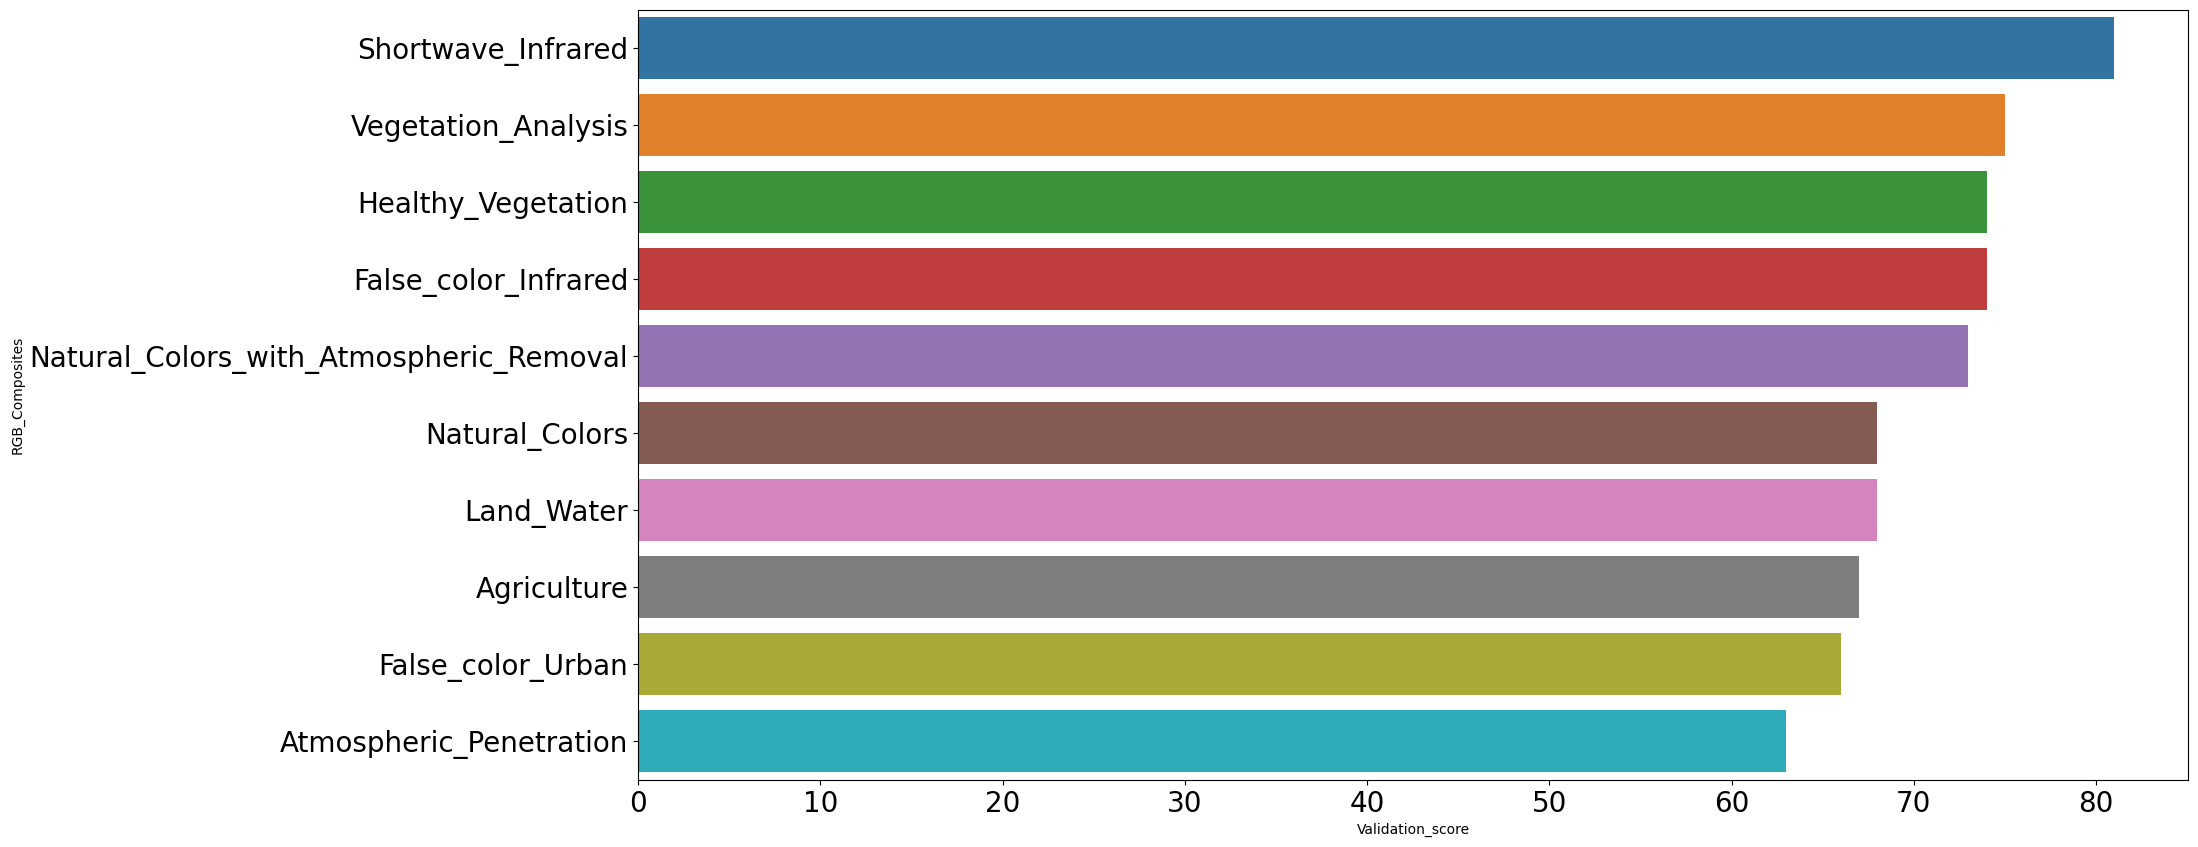

In [17]:
_=plt.figure(figsize=(20,10))

sns.barplot(data = pd.DataFrame(list(aod.score.items()),columns=['RGB_Composites', 'Validation_score']).sort_values("Validation_score",ascending=False),

            y='RGB_Composites', x='Validation_score');
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)

### Actual vs  Prediction

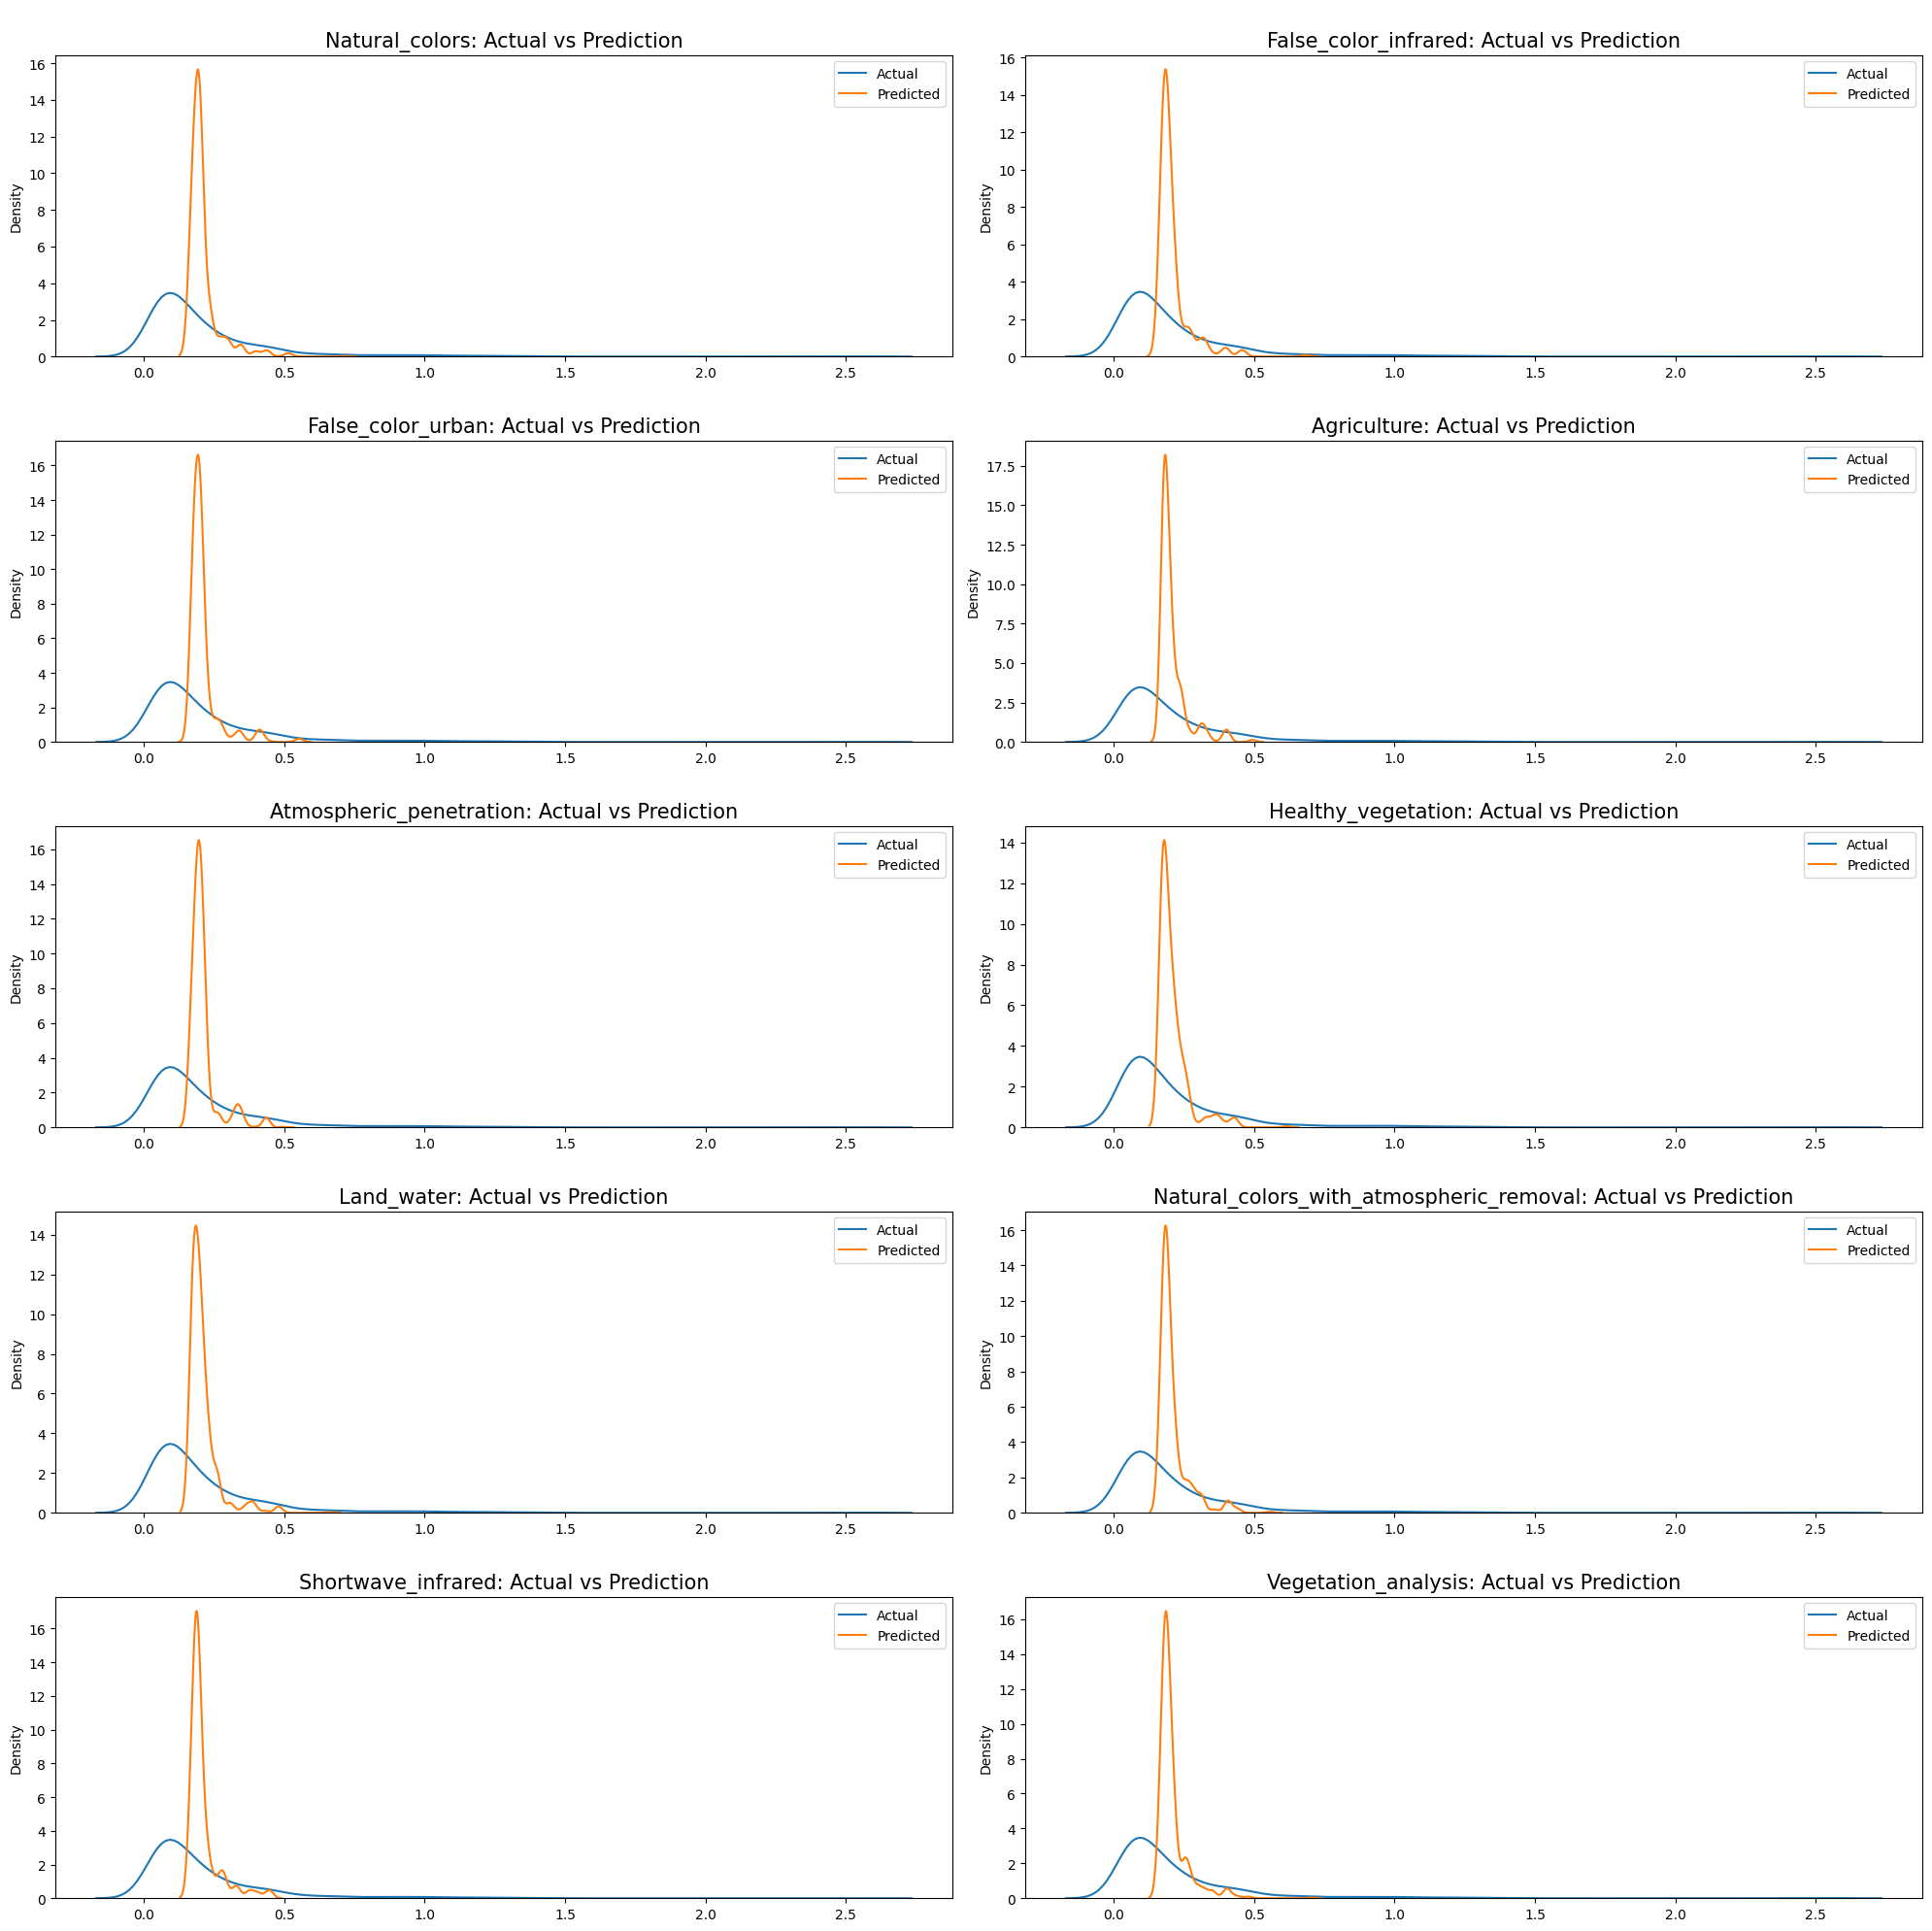

In [18]:
fig=plt.subplots(figsize=(20, 20))

for i,band  in enumerate(aod.val_pred_results.keys()):    

    _=plt.subplot(5,2,i+1,)

    _=sns.kdeplot(X_test['label'], label = 'Actual')

    _=sns.kdeplot(aod.val_pred_results[band],label='Predicted')

    _=plt.legend()

    _=plt.title(f"\n{band.capitalize()}: Actual vs Prediction",fontsize=15)

    _=plt.xlabel("")

   # _=plt.xticks(fontsize=15)

    _=plt.tight_layout()

plt.show()